# Basic Statistics for Cosmology: Exercises on $H_0$

This notebook is designed as a **student exercise**.  
You will work through **Frequentist** and **Bayesian** methods to estimate the Hubble constant $H_0$ from mock data.  

👉 This is the **exercise version** (without solutions).  
The instructor has a separate notebook with solutions.

---

## Instructions
- Fill in the code cells where you see `# TODO`.
- Answer the discussion questions in markdown cells.
- Try to first attempt on your own before checking solutions.

---

## Doing SN cosmology with a synthetic dataset, using luminosity distance relation

**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.



## Part 1: Frequentist Statistics

### Exercise 1.1: Load and Visualize Data
Generate a very simplistic SN dataset!

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    z : np.ndarray
        Array of redshifts of the supernovae.
    m : np.ndarray
        Array of observed magnitudes of the supernovae.
    sigma_m : np.ndarray
        Array of total magnitude uncertainties (measurement + intrinsic + peculiar velocity).
    name : str
        Str for the name of the sample (default is "synthetic").
    """
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    N : int
        Number of supernovae to simulate.
    H0 : float
        True Hubble constant (km/s/Mpc) used to generate the data.
    M : float
        True absolute magnitude of the supernovae.
    zmin : float
        Minimum redshift of the sample.
    zmax : float
        Maximum redshift of the sample.
    sigma_meas : float
        Measurement uncertainty in magnitudes (per SN).
    sigma_int : float
        Intrinsic scatter in magnitudes (per SN).
    v_pec : float
        RMS peculiar velocity in km/s (affects low-z distance errors).
    rng : int, np.random.Generator, or None
        Random seed or numpy random generator for reproducibility.

    Returns
    -------
    SNSample
        Dataclass containing arrays of redshift (z), observed magnitude (m), 
        total magnitude uncertainty (sigma_m), and sample name.
    """
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

In [55]:
# TODO: generate and plot data with error bars

kwargs = {'N':200, 'H0':73.0, 'M':-19.3, 'zmin':0.01, 'zmax':0.08,'sigma_meas':0.1, 'sigma_int':0.1, 'v_pec':300.0,}
obj_sample = SNSample.make_synthetic_sample = make_synthetic_sample(**kwargs)
z = obj_sample.z
m = obj_sample.m
sigma_m = obj_sample.sigma_m   

In [56]:
z_true = np.linspace(0, 0.1, 100)
m_model = mag_model(z, kwargs['H0'], kwargs['M'])


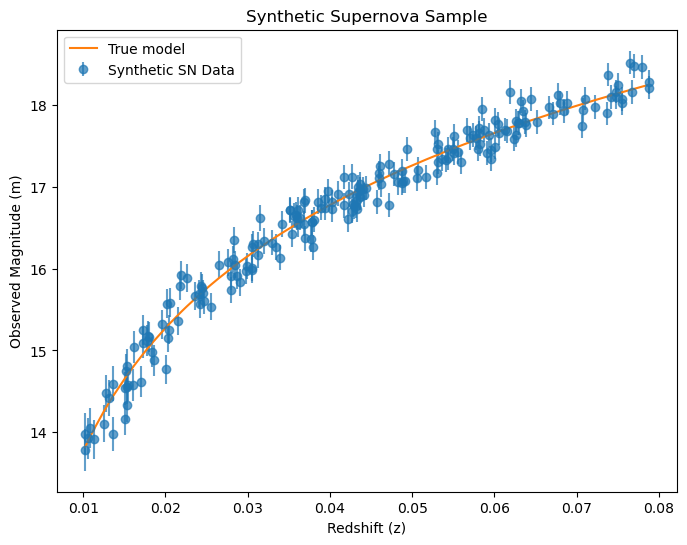

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(z, m, yerr=sigma_m, fmt='o', label='Synthetic SN Data', alpha=0.7)
ax.plot(z,m_model, label='True model' )
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Observed Magnitude (m)')
ax.set_title('Synthetic Supernova Sample')
ax.legend()

### Exercise 1.2: Define the χ² function
Write down the chi-square function for the model.

In [58]:
# TODO: define chi2 function


def chi2(theta, x, y, sigma):
    res = np.sum(((mag_model(x, *theta)-y)/sigma)**2,axis=0)
    return res

### Exercise 1.3: Minimize χ²
Find the best-fit parameters by minimizing χ².

In [59]:
H0_val = np.linspace(70,76,500)
theta = (H0_val, kwargs['M'])
chi2_val = []
for h0 in H0_val:
    theta = (h0, kwargs['M'])
    chi2_val.append(chi2(theta,z,m,sigma_m))

In [60]:
chi2_val = np.array(chi2_val)
H0_min = H0_val[np.argmin(chi2_val)]


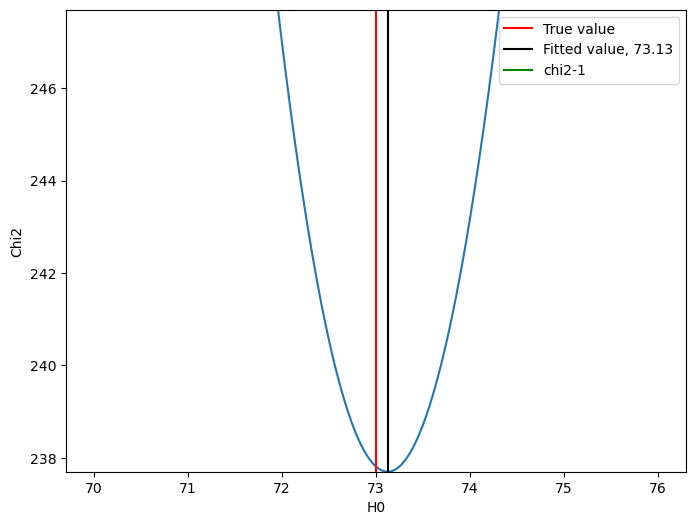

In [61]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(H0_val, chi2_val)
ax.axvline(kwargs['H0'], label='True value', color='r',)
ax.axvline(H0_min, label=f'Fitted value, {H0_min:.2f}', color='k')
ax.axhline(np.min(chi2_val)-1,color='g',label='chi2-1')
ax.set_ylim(np.min(chi2_val), np.min(chi2_val)+10.)
ax.set_ylabel('Chi2')
ax.set_xlabel('H0')
ax.legend()

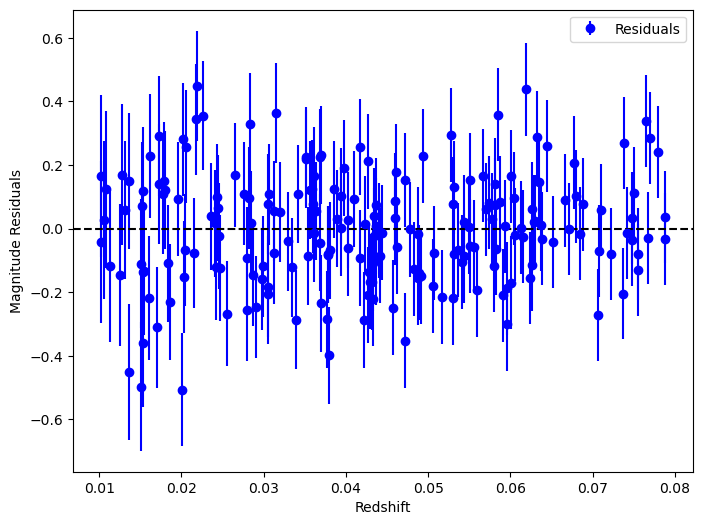

In [62]:
fig, ax = plt.subplots(figsize=(8,6))
residuals = m - mag_model(z, H0_min, kwargs['M'])
ax.errorbar(z, residuals,yerr=sigma_m, label='Residuals', color='b',fmt='o')
ax.axhline(0, color='k', linestyle='--')
ax.set_xlabel('Redshift')
ax.set_ylabel('Magnitude Residuals')
ax.legend()

In [63]:
# TODO: use numpy or scipy to minimize chi2
import scipy
H0_ic, M_ic = 70, -20
IC = np.array([H0_ic, M_ic])
res = scipy.optimize.minimize(chi2, IC, args=(z, m, sigma_m))
chi2_fit = res.fun
H0_fit, M_fit = res.x
print(f"Minimization found H0 = {H0_fit}, M = {M_fit}, with chi2_min = {chi2_fit}")
   

Minimization found H0 = 70.0365808196588, M = -19.393713082691082, with chi2_min = 237.6982849698983


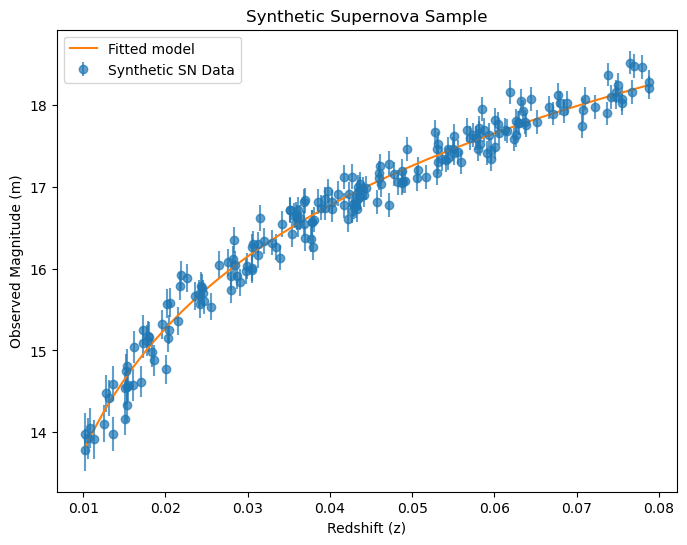

In [64]:
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(z, m, yerr=sigma_m, fmt='o', label='Synthetic SN Data', alpha=0.7)
m_fit = mag_model(z, H0_fit, M_fit)
ax.plot(z,m_fit, label='Fitted model' )
ax.set_xlabel('Redshift (z)')
ax.set_ylabel('Observed Magnitude (m)')
ax.set_title('Synthetic Supernova Sample')
ax.legend()

### Exercise 1.4: Bootstrap uncertainties
Use bootstrap resampling to estimate parameter uncertainties.

In [65]:
# TODO: implement bootstrap loop, any ideas how to do this?

n_boot = 1000

idx = np.arange(0,len(z),1)
H0_val = np.linspace(70,76,500)

H0s = np.zeros(n_boot)
for i in range(n_boot):
    rng = np.random.default_rng(i)
    idx_boot = rng.choice(idx,size=len(idx),replace=True)
    z_boot = z[idx_boot]
    m_boot = m[idx_boot]

    chi2_val = []
    for h0 in H0_val:
        theta = (h0, kwargs['M'])
        chi2_val.append(chi2(theta,z_boot,m_boot,sigma_m))
    chi2_val = np.array(chi2_val)
    H0_min = H0_val[np.argmin(chi2_val)]
    H0s[i] = H0_min


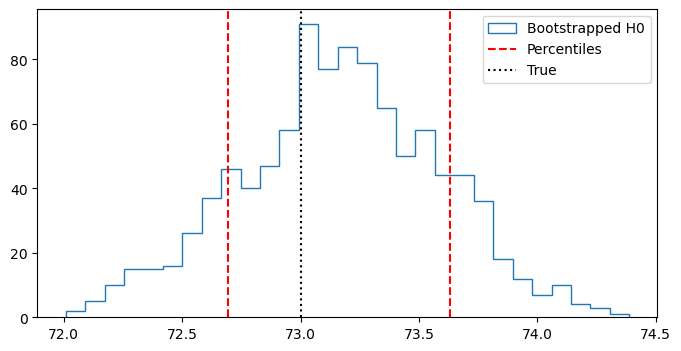

In [66]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
bins = np.linspace(np.min(H0s), np.max(H0s),30)
ax.hist(H0s, histtype = 'step', bins=bins,label = 'Bootstrapped H0')
ax.axvline(np.nanpercentile(H0s,14),ls='--',c='r')
ax.axvline(np.nanpercentile(H0s,86),ls='--',c='r',label = "Percentiles")
ax.axvline(kwargs['H0'],ls = ':', c = 'k', label = 'True')
ax.legend()


### Exercise 1.5: p-value
Calculate a p-value from the sampled probability

In [67]:
# TODO: let's calculate a p-value from the sampled probability

def p_val(x,sample):
    mask = sample>x
    p_value = np.sum(mask)/len(sample)
    return p_value

pval_true = p_val(kwargs['H0'],H0s)
print(f"The true value has a p-value = {pval_true:.1e}")

The true value has a p-value = 6.7e-01


### Exercise 1.6: Compare with MLE
Explain how minimizing χ² relates to Maximum Likelihood Estimation.

👉 *Write your discussion here*

## Part 2: Bayesian Statistics

### Exercise 2.1: Bayes' theorem
Write Bayes' theorem and identify prior, likelihood, posterior.

👉 *Write Bayes' theorem in your own words here*

### Exercise 2.2: Compute Posterior on a Grid
Define priors and likelihood, then compute posterior on a parameter grid.

In [167]:
def prior_unif(x,xmin=50, xmax=100):
    p = np.where((x>xmin)&(x<xmax),1/(xmax-xmin),0)
    return np.sum(p)

def prior_gauss(x,mu=-19.3,sigma=0.05):
    return np.sum(-0.5*((x-mu)/sigma)**2)

def ll(theta,x,y,sigma):
    H0, M  = theta
    y_model = mag_model(x, H0, M)
    single = -0.5*np.log(2*np.pi*sigma**2) - 0.5*(y-y_model)**2/sigma**2
    return np.sum(single)

def posterior(x,y,sigma,H0s = np.linspace(65,80,500), Ms = np.linspace(-19.6,-19,800)):
    post = []
    for h0 in H0s:
        for M in Ms:
            #M = kwargs['M']  # Fix M to the true value for this posterior
            p = _get_post(x,y,sigma,h0,M)
            post.append(p)
    post = np.array(post).reshape((len(H0s),len(Ms))).T
    H0_grid, M_grid = np.meshgrid(H0s,Ms)
    post /= np.trapz(np.trapz(post, H0s, axis=1), Ms, axis=0)
    return H0_grid, M_grid, post

def _get_post(x,y,sigma,H0,M):
    prior = prior_unif(H0)+prior_gauss(M)
    #prior = 1
    ll_val = ll((H0,M),x,y,sigma)
    return np.exp(prior+ll_val)


/var/folders/9j/zk4h50g505d635j69p9tgwbc0000gp/T/ipykernel_85520/98868548.py:23: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  post /= np.trapz(np.trapz(post, H0s, axis=1), Ms, axis=0)


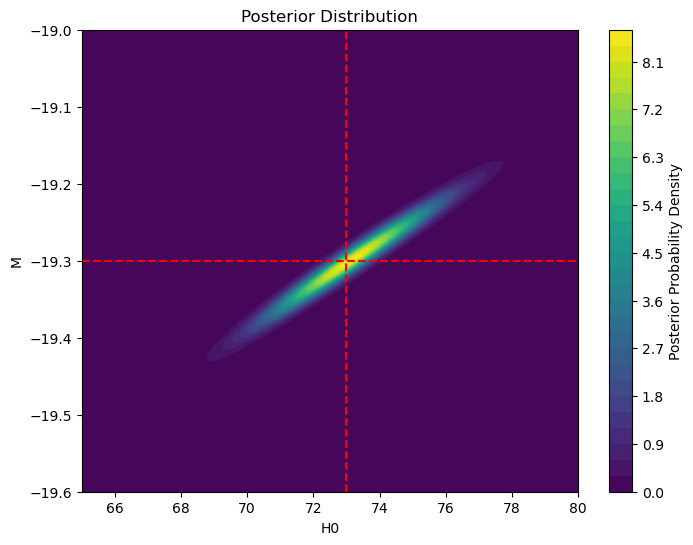

In [168]:
H0_b, M_b, post = posterior(z,m,sigma_m)

fig, ax = plt.subplots(1,1, figsize = (8,6))
c = ax.contourf(H0_b, M_b, post, levels=30, cmap='viridis')
ax.axhline(kwargs['M'], label='True M', color='r', ls='--')
ax.axvline(kwargs['H0'], label='True H0', color='r',ls='--')
ax.set_xlabel('H0')
ax.set_ylabel('M')
ax.set_title('Posterior Distribution')
fig.colorbar(c, ax=ax, label='Posterior Probability Density')

### Exercise 2.3: Normalize Posterior and Extract Marginal Estimates
Normalize posterior, compute marginal estimations of $H_0$ and $M$

/var/folders/9j/zk4h50g505d635j69p9tgwbc0000gp/T/ipykernel_85520/4194489563.py:5: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_H0 = np.trapz(post, M_b, axis=0)
/var/folders/9j/zk4h50g505d635j69p9tgwbc0000gp/T/ipykernel_85520/4194489563.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  p_M  = np.trapz(post, H0_b, axis=1)


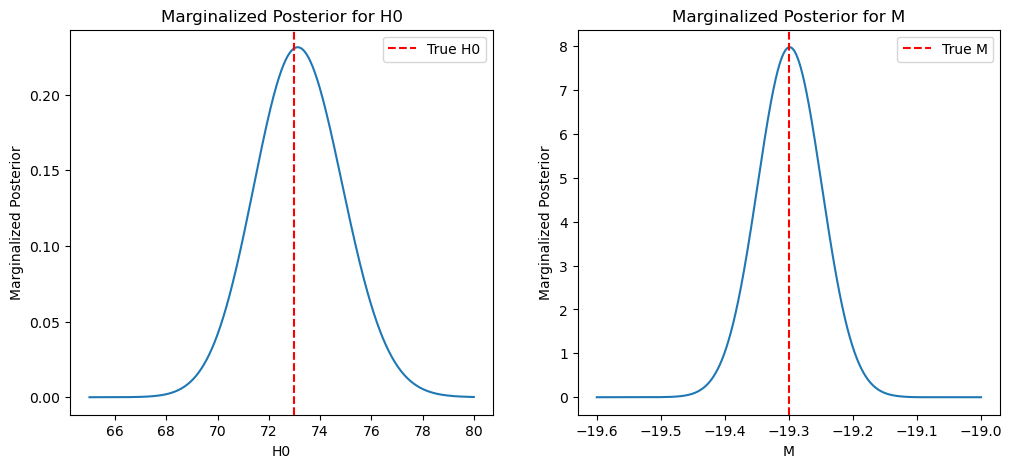

In [169]:
# TODO: normalize posterior
# TODO: compute marginal distributions


p_H0 = np.trapz(post, M_b, axis=0)
p_M  = np.trapz(post, H0_b, axis=1)


fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(H0_b[0,:], p_H0)
ax[0].axvline(kwargs['H0'], label='True H0', color='r', ls='--')
ax[0].set_xlabel('H0')
ax[0].set_ylabel('Marginalized Posterior')
ax[0].set_title('Marginalized Posterior for H0')
ax[0].legend()
ax[1].plot(M_b[:,0], p_M)
ax[1].axvline(kwargs['M'], label='True M', color='r', ls='--')
ax[1].set_xlabel('M')
ax[1].set_ylabel('Marginalized Posterior')
ax[1].set_title('Marginalized Posterior for M')
ax[1].legend()


### Exercise 2.4: Credible Interval
Compute the 68% credible interval from the posterior.

In [170]:
# TODO: credible interval calculation

### Exercise 2.5: Compare with Frequentist Result
Compare Bayesian and Frequentist estimates of $H_0$.

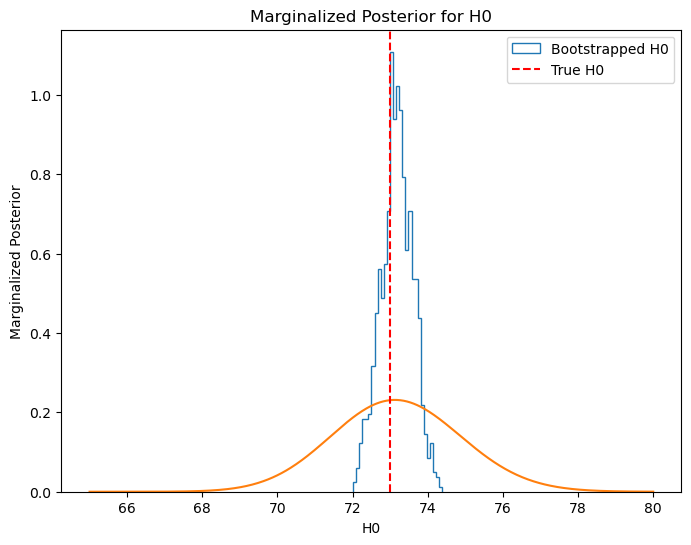

In [171]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.hist(H0s, histtype = 'step', bins=bins,label = 'Bootstrapped H0',density=True)
ax.plot(H0_b[0,:], p_H0)
ax.axvline(kwargs['H0'], label='True H0', color='r', ls='--')
ax.set_xlabel('H0')
ax.set_ylabel('Marginalized Posterior')
ax.set_title('Marginalized Posterior for H0')
ax.legend()

👉 *Write your comparison here*

## Part 3: Re-do with `Cobaya`

In [216]:
def ll_cobaya(H0,M):
    return ll((H0,M),z,m,sigma_m)


info_dict = {'params': {'H0': {'prior':{'min': 50, 'max': 100, },'latex': r'H_0',},
                        'M': {'prior':{'dist':'norm','loc': -19.3, 'scale': 5e-2,}, 'latex': r'M', },
                        },
             'likelihood': {
                 'my_sn_likelihood': {'external': ll_cobaya}
             },
                'sampler': {'mcmc': {'max_tries':10000, 'Rminus1_stop': 0.001}}
            }

#  We import Cobaya
from cobaya.run import run
# Now we run!
updated_info, sampler = run(info_dict)

In [217]:
#  We import Cobaya
from cobaya.run import run
# Now we run!
updated_info, sampler = run(info_dict)

[my_sn_likelihood] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: H0:56.1101, M:-19.34304
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {my_sn_likelihood: 58600.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-08-28 17:07:22 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.038
[mcmc]  - Convergence of means: R-1 = 0.485855 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergenc

Estimate $H_0$ using Cobaya and Bayesian Statistics and compare

[root] *WARNING* outlier fraction 0.00203125 
Mean:
[ 73.16639993 -19.29930709]
Covariance matrix:
[[2.88237279e+00 8.02518445e-02]
 [8.02518445e-02 2.36670401e-03]]


<Figure size 640x480 with 0 Axes>

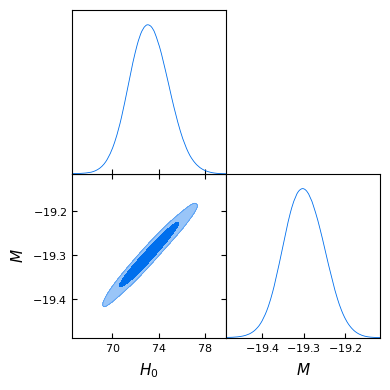

In [218]:
# Import corresponding modules from GetDist
from getdist.mcsamples import loadMCSamples, MCSamplesFromCobaya
import getdist.plots as gdplt

# Load the chains and the updated config file from the previous run
gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])

# Analyze the chains (print the mean and covmat according to GetDist documentation)
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)

# PLOT THE CHAINS (have a look at the DEMO above from GetDist)
# The goal is to produce a triangle plot

plt.figure()
gdplot = gdplt.get_subplot_plotter()
gdplot.triangle_plot(gd_sample, ["H0", "M"], filled=True)
plt.show()

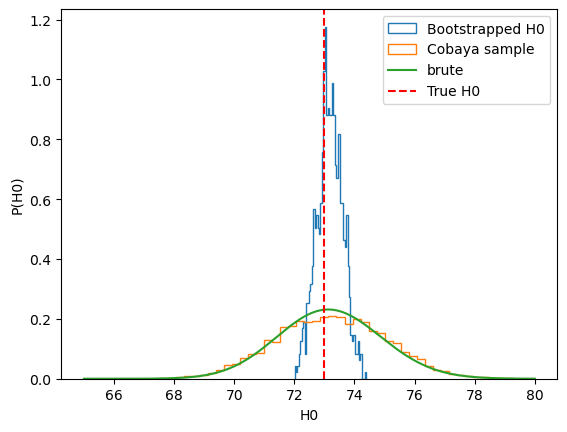

In [219]:
H0_c = np.array(sampler.products()['sample']['H0'])


fig,ax = plt.subplots(1,1)
ax.hist(H0s, histtype = 'step', bins=50,label = 'Bootstrapped H0',density=True)
ax.hist(H0_c, density=True, histtype='step',bins=50,label='Cobaya sample')
ax.plot(H0_b[0,:], p_H0,label = 'brute')
ax.axvline(kwargs['H0'], label='True H0', color='r', ls='--')
ax.set_xlabel("H0")
ax.set_ylabel('P(H0)')
ax.legend()

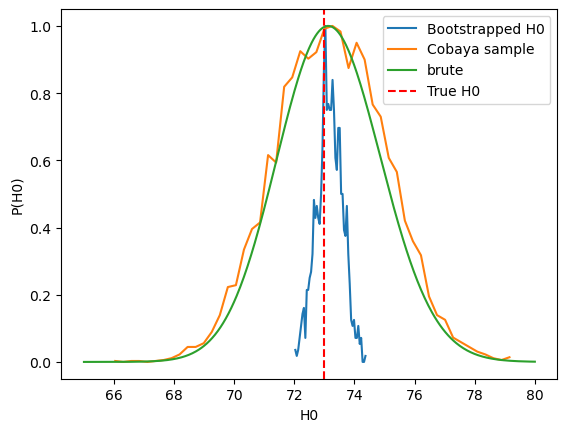

In [220]:
counts_c,bins_c = np.histogram(H0_c,bins=50)
bins_c = 0.5 * (bins_c[:-1] + bins_c[1:])
counts_b, bins_b = np.histogram(H0s, bins=50)
bins_b = 0.5 * (bins_b[:-1] + bins_b[1:])

counts_c = counts_c.astype(float) / np.max(counts_c)
counts_b = counts_b.astype(float) / np.max(counts_b)

fig,ax = plt.subplots(1,1)
ax.plot(bins_b, counts_b,  label = 'Bootstrapped H0',)
ax.plot(bins_c, counts_c,label='Cobaya sample')
ax.plot(H0_b[0,:], p_H0/np.max(p_H0),label = 'brute')
ax.axvline(kwargs['H0'], label='True H0', color='r', ls='--')
ax.set_xlabel("H0")
ax.set_ylabel('P(H0)')
ax.legend()

Running NumPyro with explicit likelihood...


sample: 100%|██████████| 3000/3000 [00:01<00:00, 1939.85it/s, 15 steps of size 1.33e-01. acc. prob=0.93]




                mean       std    median      5.0%     95.0%     n_eff     r_hat
        H0     73.22      1.69     73.19     70.44     75.93    309.72      1.00
         M    -19.30      0.05    -19.30    -19.37    -19.21    317.78      1.00

Number of divergences: 0

Running NumPyro with implicit likelihood...


sample: 100%|██████████| 3000/3000 [00:01<00:00, 1662.66it/s, 7 steps of size 1.52e-01. acc. prob=0.92] 




                mean       std    median      5.0%     95.0%     n_eff     r_hat
        H0     73.00      1.66     72.95     70.27     75.63    403.68      1.00
         M    -19.30      0.05    -19.30    -19.38    -19.23    404.59      1.00

Number of divergences: 0


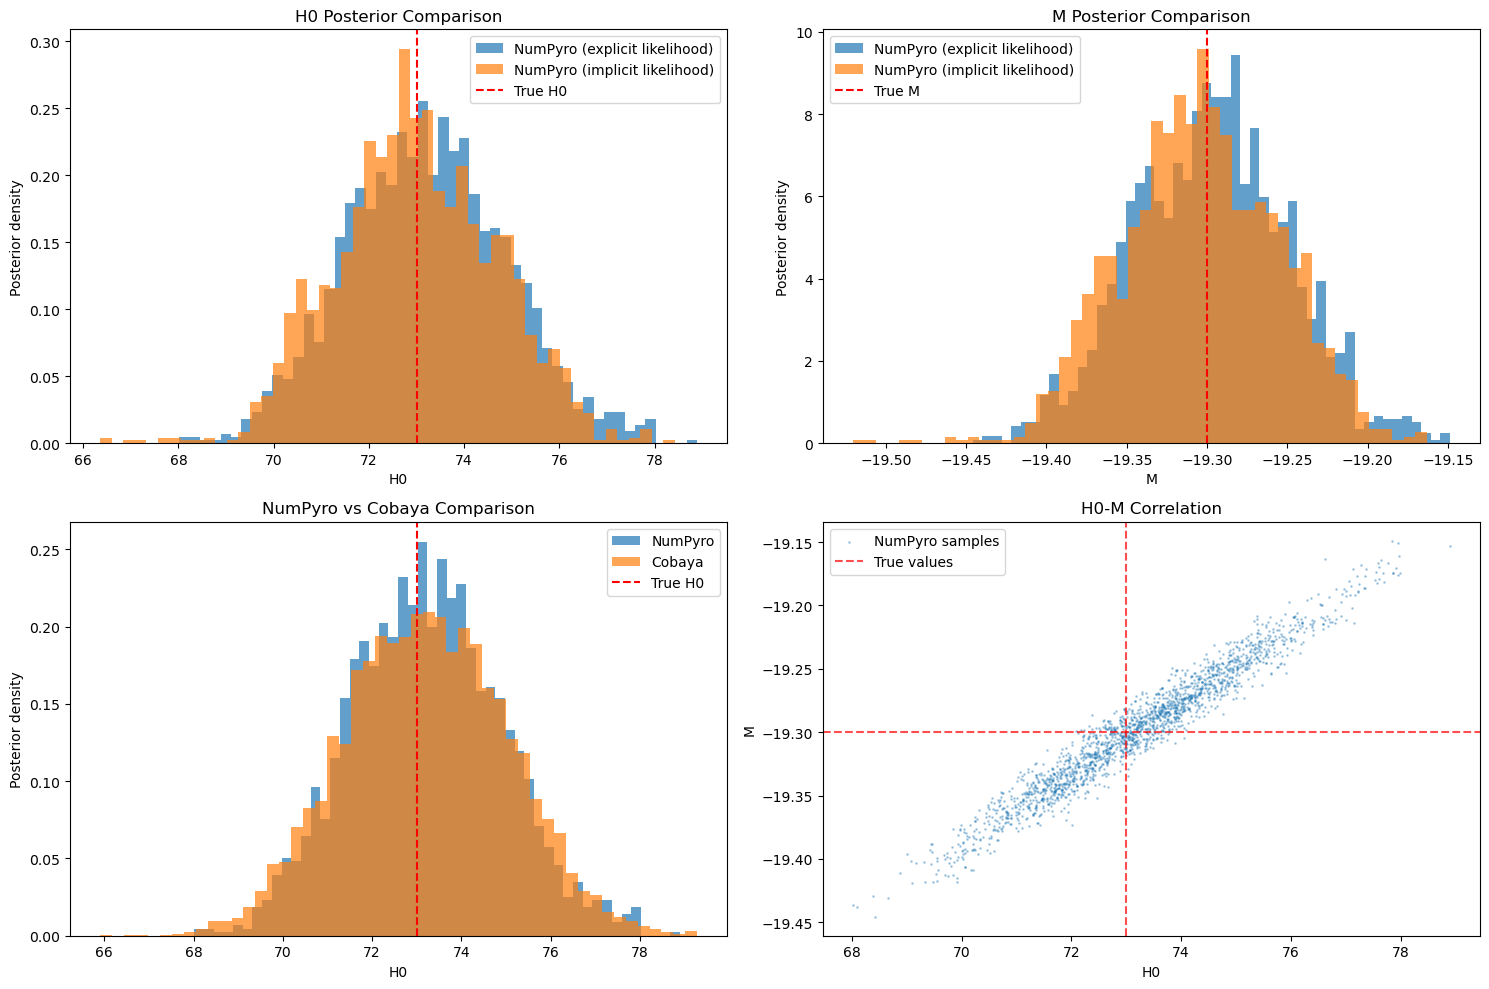

Explicit likelihood - H0 mean: 73.22 ± 1.69
Implicit likelihood - H0 mean: 73.00 ± 1.66
True H0: 73.0
Explicit likelihood - M mean: -19.297 ± 0.048
Implicit likelihood - M mean: -19.305 ± 0.048
True M: -19.3


In [222]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.numpy as jnp

# Define the likelihood function (similar to Cobaya approach)
def log_likelihood_jax(H0, M, z, m_obs, sigma_m):
    """
    Explicit log-likelihood function for supernova data.
    This is the JAX version of the likelihood used in Cobaya.
    """
    # Calculate model prediction
    mu_model = M + 5.0 * jnp.log10(c_km_s * z / H0) + 25.0
    
    # Calculate log-likelihood (same as Cobaya version)
    chi2 = jnp.sum(((m_obs - mu_model) / sigma_m) ** 2)
    log_like = -0.5 * chi2 - 0.5 * jnp.sum(jnp.log(2 * jnp.pi * sigma_m**2))
    
    return log_like

def numpyro_model_explicit(z, m_obs, sigma_m):
    """
    NumPyro model with explicit likelihood calculation (similar to Cobaya).
    """
    # Sample from priors (same as before)
    H0 = numpyro.sample('H0', dist.Uniform(50., 100.))
    M = numpyro.sample('M', dist.Normal(-19.3, 0.05))
    
    # Calculate log-likelihood using our explicit function
    log_like = log_likelihood_jax(H0, M, z, m_obs, sigma_m)
    
    # Add the likelihood to the model using numpyro.factor
    numpyro.factor('likelihood', log_like)

# Alternative: Original implicit approach (for comparison)
def numpyro_model_implicit(z, m_obs, sigma_m):
    """
    Original NumPyro model with implicit likelihood.
    """
    H0 = numpyro.sample('H0', dist.Uniform(50., 100.))
    M = numpyro.sample('M', dist.Normal(-19.3, 0.05))
    mu = M + 5.0 * jnp.log10(c_km_s * z / H0) + 25.0
    numpyro.sample('obs', dist.Normal(mu, sigma_m), obs=m_obs)

# Run MCMC with explicit likelihood (similar to Cobaya)
print("Running NumPyro with explicit likelihood...")
nuts_kernel_explicit = NUTS(numpyro_model_explicit)
mcmc_explicit = MCMC(nuts_kernel_explicit, num_warmup=1000, num_samples=2000)
mcmc_explicit.run(jax.random.PRNGKey(0), z=z, m_obs=m, sigma_m=sigma_m)
mcmc_explicit.print_summary()

posterior_samples_explicit = mcmc_explicit.get_samples()
H0_samples_explicit = posterior_samples_explicit['H0']
M_samples_explicit = posterior_samples_explicit['M']

# Run MCMC with implicit likelihood (original approach)
print("\nRunning NumPyro with implicit likelihood...")
nuts_kernel_implicit = NUTS(numpyro_model_implicit)
mcmc_implicit = MCMC(nuts_kernel_implicit, num_warmup=1000, num_samples=2000)
mcmc_implicit.run(jax.random.PRNGKey(1), z=z, m_obs=m, sigma_m=sigma_m)
mcmc_implicit.print_summary()

posterior_samples_implicit = mcmc_implicit.get_samples()
H0_samples_implicit = posterior_samples_implicit['H0']
M_samples_implicit = posterior_samples_implicit['M']

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Plot H0 comparison
ax[0,0].hist(H0_samples_explicit, bins=50, density=True, alpha=0.7, label='NumPyro (explicit likelihood)')
ax[0,0].hist(H0_samples_implicit, bins=50, density=True, alpha=0.7, label='NumPyro (implicit likelihood)')
ax[0,0].axvline(kwargs['H0'], color='r', ls='--', label='True H0')
ax[0,0].set_xlabel('H0')
ax[0,0].set_ylabel('Posterior density')
ax[0,0].set_title('H0 Posterior Comparison')
ax[0,0].legend()

# Plot M comparison
ax[0,1].hist(M_samples_explicit, bins=50, density=True, alpha=0.7, label='NumPyro (explicit likelihood)')
ax[0,1].hist(M_samples_implicit, bins=50, density=True, alpha=0.7, label='NumPyro (implicit likelihood)')
ax[0,1].axvline(kwargs['M'], color='r', ls='--', label='True M')
ax[0,1].set_xlabel('M')
ax[0,1].set_ylabel('Posterior density')
ax[0,1].set_title('M Posterior Comparison')
ax[0,1].legend()

# Compare with Cobaya (if available)
if 'H0_c' in locals():
    ax[1,0].hist(H0_samples_explicit, bins=50, density=True, alpha=0.7, label='NumPyro')
    ax[1,0].hist(H0_c, bins=50, density=True, alpha=0.7, label='Cobaya')
    ax[1,0].axvline(kwargs['H0'], color='r', ls='--', label='True H0')
    ax[1,0].set_xlabel('H0')
    ax[1,0].set_ylabel('Posterior density')
    ax[1,0].set_title('NumPyro vs Cobaya Comparison')
    ax[1,0].legend()
else:
    ax[1,0].text(0.5, 0.5, 'Run Cobaya section first\nfor comparison', 
                ha='center', va='center', transform=ax[1,0].transAxes)
    ax[1,0].set_title('NumPyro vs Cobaya Comparison')

# Scatter plot showing correlation
ax[1,1].scatter(H0_samples_explicit, M_samples_explicit, alpha=0.3, s=1, label='NumPyro samples')
ax[1,1].axvline(kwargs['H0'], color='r', ls='--', alpha=0.7)
ax[1,1].axhline(kwargs['M'], color='r', ls='--', alpha=0.7, label='True values')
ax[1,1].set_xlabel('H0')
ax[1,1].set_ylabel('M')
ax[1,1].set_title('H0-M Correlation')
ax[1,1].legend()

plt.tight_layout()
plt.show()

# Print comparison statistics
print(f"Explicit likelihood - H0 mean: {jnp.mean(H0_samples_explicit):.2f} ± {jnp.std(H0_samples_explicit):.2f}")
print(f"Implicit likelihood - H0 mean: {jnp.mean(H0_samples_implicit):.2f} ± {jnp.std(H0_samples_implicit):.2f}")
print(f"True H0: {kwargs['H0']}")
print(f"Explicit likelihood - M mean: {jnp.mean(M_samples_explicit):.3f} ± {jnp.std(M_samples_explicit):.3f}")
print(f"Implicit likelihood - M mean: {jnp.mean(M_samples_implicit):.3f} ± {jnp.std(M_samples_implicit):.3f}")
print(f"True M: {kwargs['M']}")


## Understanding NumPyro's Probabilistic Programming

NumPyro is a **probabilistic programming language** that uses **Monte Carlo sampling** to perform Bayesian inference. Let me explain why it needs to "sample" and how it works:

### Why does NumPyro need to sample?

**The core problem**: In Bayesian inference, we want to compute the posterior distribution:
$$P(\theta|data) = \frac{P(data|\theta) \times P(\theta)}{P(data)}$$

The denominator $P(data)$ (called the **evidence** or **marginal likelihood**) requires integrating over all possible parameter values:
$$P(data) = \int P(data|\theta) \times P(\theta) \, d\theta$$

**This integral is usually impossible to compute analytically** for realistic problems!

### NumPyro's Solution: MCMC Sampling

Instead of computing the posterior exactly, NumPyro:
1. **Generates samples** from the posterior distribution using MCMC
2. These samples approximate the true posterior distribution
3. From the samples, we can estimate any quantity we want (means, credible intervals, etc.)

### How the explicit model works:

```python
def numpyro_model_explicit(z, m_obs, sigma_m):
    # 1. SAMPLE from priors - these are the "random variables"
    H0 = numpyro.sample('H0', dist.Uniform(50., 100.))  # Sample H0 value
    M = numpyro.sample('M', dist.Normal(-19.3, 0.05))   # Sample M value
    
    # 2. COMPUTE log-likelihood for these sampled values
    log_like = log_likelihood_jax(H0, M, z, m_obs, sigma_m)
    
    # 3. TELL NumPyro about the likelihood using numpyro.factor
    numpyro.factor('likelihood', log_like)
```

### What happens during MCMC:

1. **Initialization**: Start with some values for H0 and M
2. **Propose new values**: NUTS sampler proposes new H0, M values
3. **Evaluate**: Compute prior probability + likelihood for these values
4. **Accept/Reject**: Based on Metropolis-Hastings acceptance rule
5. **Repeat**: Do this thousands of times to explore the parameter space
6. **Result**: A chain of samples that approximates P(H0, M | data)

### Why `numpyro.sample` vs `numpyro.factor`:

- **`numpyro.sample('H0', dist.Uniform(...))`**: "H0 is a random variable I want to infer"
- **`numpyro.factor('likelihood', log_like)`**: "Add this log-probability to the model"

The combination creates: **log P(H0, M | data) ∝ log P(H0) + log P(M) + log_likelihood**

In [ ]:
# Let's see what happens inside one MCMC step for both approaches

def demonstrate_one_mcmc_step():
    """Show what happens in one MCMC iteration for both approaches"""
    
    # Imagine MCMC proposes these parameter values:
    H0_proposed = 72.5
    M_proposed = -19.28
    
    print("=== One MCMC Step Demonstration ===")
    print(f"Proposed parameters: H0={H0_proposed}, M={M_proposed}")
    print()
    
    # EXPLICIT APPROACH
    print("EXPLICIT APPROACH:")
    print("1. Calculate model prediction:")
    mu_model = M_proposed + 5.0 * jnp.log10(c_km_s * z / H0_proposed) + 25.0
    print(f"   mu_model = M + 5*log10(c*z/H0) + 25 = {mu_model[:3]}... (first 3 values)")
    
    print("2. Calculate log-likelihood manually:")
    chi2 = jnp.sum(((m - mu_model) / sigma_m) ** 2)
    log_like = -0.5 * chi2 - 0.5 * jnp.sum(jnp.log(2 * jnp.pi * sigma_m**2))
    print(f"   chi2 = {chi2:.2f}")
    print(f"   log_likelihood = {log_like:.2f}")
    
    print("3. Calculate log-prior:")
    log_prior_H0 = jnp.log(1/(100-50)) if 50 <= H0_proposed <= 100 else -jnp.inf
    log_prior_M = -0.5 * ((M_proposed - (-19.3))/0.05)**2 - 0.5*jnp.log(2*jnp.pi*0.05**2)
    print(f"   log_prior(H0) = {log_prior_H0:.2f}")
    print(f"   log_prior(M) = {log_prior_M:.2f}")
    
    print("4. Total log-posterior:")
    log_posterior_explicit = log_prior_H0 + log_prior_M + log_like
    print(f"   log_posterior = {log_posterior_explicit:.2f}")
    print()
    
    # IMPLICIT APPROACH  
    print("IMPLICIT APPROACH:")
    print("1. NumPyro automatically does steps 1-4 when you write:")
    print("   numpyro.sample('obs', dist.Normal(mu, sigma_m), obs=m_obs)")
    print("2. It calculates the same log_likelihood internally")
    print("3. It adds prior probabilities from numpyro.sample statements")
    print("4. Result: Same log_posterior value!")
    print()
    
    print("KEY INSIGHT:")
    print("Both approaches compute EXACTLY the same posterior probability,")
    print("but the explicit approach shows you all the mathematical steps!")

# Run the demonstration
demonstrate_one_mcmc_step()

### Conceptual Difference: Generative vs. Explicit

**IMPLICIT (Generative) Approach:**
```python
def numpyro_model_implicit(z, m_obs, sigma_m):
    H0 = numpyro.sample('H0', dist.Uniform(50., 100.))  # "H0 comes from this prior"
    M = numpyro.sample('M', dist.Normal(-19.3, 0.05))   # "M comes from this prior"  
    mu = M + 5.0 * jnp.log10(c_km_s * z / H0) + 25.0   # "Calculate expected magnitude"
    numpyro.sample('obs', dist.Normal(mu, sigma_m), obs=m_obs)  # "Data comes from this distribution"
```
🎯 **Philosophy**: "I'm describing how the data was generated"

**EXPLICIT (Factor) Approach:**
```python
def numpyro_model_explicit(z, m_obs, sigma_m):
    H0 = numpyro.sample('H0', dist.Uniform(50., 100.))  # "H0 is unknown, sample it"
    M = numpyro.sample('M', dist.Normal(-19.3, 0.05))   # "M is unknown, sample it"
    log_like = log_likelihood_jax(H0, M, z, m_obs, sigma_m)  # "Calculate likelihood explicitly"
    numpyro.factor('likelihood', log_like)  # "Add this to the posterior probability"
```
🎯 **Philosophy**: "I'm directly specifying the likelihood function"

### Why sampling is essential:

**The sampling (`numpyro.sample`) tells NumPyro:**
1. "These are the parameters I want to learn about" 
2. "Here are their prior distributions"
3. "Please explore different values during MCMC"

**Without sampling, NumPyro wouldn't know:**
- Which variables are parameters vs. fixed data
- What their prior distributions should be
- What values to try during the MCMC exploration

**Think of it like:** NumPyro is exploring a landscape of possible (H0, M) values, and the sampling tells it which directions it's allowed to move and how likely each region is a priori.